In [2]:
import os
import json
import ccxt
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)

%matplotlib inline

^C


In [3]:
config = json.load(open('../logger_config.json'))
config
exchange = ccxt.binance({
    "apiKey": config["BINANCE_API_KEY"],
    "secret": config["BINANCE_SECRET_KEY"]
})

In [3]:
balance = exchange.fetch_balance()
tickers = exchange.fetch_tickers()

304

In [17]:
# ticker_list = ["BTC/BUSD", "ETH/BUSD", "LRC/BUSD"]

binance_tickers = list(tickers.keys())
busd_tickers = binance_tickers.copy() 

for item in binance_tickers:
    if "/BUSD" not in item:
        busd_tickers.remove(item)

iterations = 1
for ticker in busd_tickers:

    df_temp = pd.DataFrame(exchange.fetch_ohlcv(ticker, "1h"), columns=["date", "open", "high", "low", "close", "volume"])
    df_temp["date"] = pd.to_datetime(df_temp["date"], unit="ms")
    df_temp["pct_change_1h"] = df_temp["close"].pct_change()
    ticker_name = ticker.replace("/", "-")
    df_temp.to_csv(f"../data/binance_benchmark/one_hour/{ticker_name}.csv")

In [53]:
def get_hours_data(open_path, save_path, hours):
    ''' Filter hourly data specified time interval'''
    
    for filename in os.listdir(open_path):
        df = pd.read_csv(f"{open_path}/{filename}")
        df['date'] = pd.to_datetime(df["date"])
        df = df[(df['date'] >= "2021-12-13 00:00:00")]
        df_new = pd.DataFrame(columns=df.columns)
        
        for i in range(0, df.shape[0], hours):
            df_new = df_new.append(df.iloc[i], ignore_index=True)
        
        df_new["pct_change_24h"] = df_new["close"].pct_change()
        df_new = df_new.dropna()
        df_new["ticker"] = str(filename).replace(".csv", "")
            
        df_new.to_csv(f"{save_path}/{filename}", index=False)

In [73]:
open_path = "../data/binance_benchmark/one_hour"
save_path_4h = "../data/binance_benchmark/four_hours"
save_path_6h = "../data/binance_benchmark/six_hours"
save_path_8h = "../data/binance_benchmark/eight_hours"
save_path_12h = "../data/binance_benchmark/twelve_hours"
save_path_24h = "../data/binance_benchmark/twentyfour_hours"


get_hours_data(open_path, save_path_4h, 4)
get_hours_data(open_path, save_path_6h, 6)
get_hours_data(open_path, save_path_8h, 8)
get_hours_data(open_path, save_path_12h, 12)
get_hours_data(open_path, save_path_24h, 24)

In [46]:
def merge_ticker_data(path, base_token_pair='BTC-BUSD'):
    
    df_data = pd.read_csv(f'{path}\\{base_token_pair}.csv')
    df_data['date'] = pd.to_datetime(df_data['date'])
    df_data = df_data.rename({'close': base_token_pair}, axis='columns')
    df_data = df_data[['date', base_token_pair]]
    
    df_merge = df_data.copy()
    
    for filename in os.listdir(path):
        token_pair = filename.replace(".csv", "")
        f = os.path.join(path, filename)

        # checking if it is a file
        if os.path.isfile(f) and f != f'{path}\\{base_token_pair}.csv':
            try:
                df_new = pd.read_csv(f)
                df_new['date'] = pd.to_datetime(df_new['date'])
                df_new = df_new.rename({'close': token_pair}, axis='columns')
                df_new = df_new[['date', token_pair]]
                df_merge = df_merge.merge(df_new, how='left', on='date')
                
            except Exception as e:
                print(e)
    
    df = df_merge.set_index('date')
    df = df.pct_change()
    
    return df

In [48]:
open_path_1 = "../data/binance_benchmark/one_hour"
open_path_4 = "../data/binance_benchmark/four_hours"
open_path_6 = "../data/binance_benchmark/six_hours"
open_path_8 = "../data/binance_benchmark/eight_hours"
open_path_12 = "../data/binance_benchmark/twelve_hours"
open_path_24 = "../data/binance_benchmark/twentyfour_hours"

df_merged_1h = merge_ticker_data(open_path_1, base_token_pair='BTC-BUSD')
df_merged_4h = merge_ticker_data(open_path_4, base_token_pair='BTC-BUSD')
df_merged_6h = merge_ticker_data(open_path_6, base_token_pair='BTC-BUSD')
df_merged_8h = merge_ticker_data(open_path_8, base_token_pair='BTC-BUSD')
df_merged_12h = merge_ticker_data(open_path_12, base_token_pair='BTC-BUSD')
df_merged_24h = merge_ticker_data(open_path_24, base_token_pair='BTC-BUSD')


In [62]:
def get_top10_picks(df):
    ''' Generating the top 10 weekly picks 
        
        This function generates the weekly picks by taking the top 10 performers of the current week
    '''
    
    df_ = df.to_numpy()
    weekly_returns = {0: np.nan} # Weekly returns dict starts with nan because we look 1 week ahead 
    

    for i in range(df_.shape[0]-1): # The for loop is -1 because we look 1 week ahead

        try:
            top_10 = df.iloc[i].sort_values(ascending=False).index.to_list()[:10]
            next_week = df.iloc[i+1]
            returns = []

            for token in top_10:
                returns.append(next_week[token])

            returns_mean = np.mean(returns)
            weekly_returns[i+1] = returns_mean
            
        except Exception as e:
            print(e)
    
    df_returns = pd.DataFrame.from_dict(weekly_returns, orient='index')
    df_returns = df_returns.rename({0: 'Top_10'}, axis='columns')
    df_returns = df_returns.set_index(df.index.values)
    return df_returns

In [63]:
df_top10_1h = get_top10_picks(df_merged_1h)
df_top10_4h = get_top10_picks(df_merged_4h)
df_top10_6h = get_top10_picks(df_merged_6h)
df_top10_8h = get_top10_picks(df_merged_8h)
df_top10_12h = get_top10_picks(df_merged_12h)
df_top10_24h = get_top10_picks(df_merged_24h)

df_strategy_1h = pd.concat([df_merged_1h[['BTC-BUSD', 'ETH-BUSD']], df_top10_1h], axis=1)
df_strategy_4h = pd.concat([df_merged_4h[['BTC-BUSD', 'ETH-BUSD']], df_top10_4h], axis=1)
df_strategy_6h = pd.concat([df_merged_6h[['BTC-BUSD', 'ETH-BUSD']], df_top10_6h], axis=1)
df_strategy_8h = pd.concat([df_merged_8h[['BTC-BUSD', 'ETH-BUSD']], df_top10_8h], axis=1)
df_strategy_12h = pd.concat([df_merged_12h[['BTC-BUSD', 'ETH-BUSD']], df_top10_12h], axis=1)
df_strategy_24h = pd.concat([df_merged_24h[['BTC-BUSD', 'ETH-BUSD']], df_top10_24h], axis=1)

In [64]:
def cummulative_returns(df, start=0, end=-1):
    ''' Calculates cummulative returns of the tokens in the dataframe'''
    
    df_select = df.copy() + 1
    df_select = df_select.iloc[start:end] 
    
    df_ = df_select.to_numpy()
    df_new = np.ones(df_.shape)
    
    for i in range(df_.shape[0]):        
        
        for j in range(df_.shape[1]):
            try:
                if np.isnan(df_[i-1,j]) != False:
                    pass
                else:
                    df_new[i,j] = df_[i,j] * df_new[i-1,j]
            except: 
                pass
    
    df_results = pd.DataFrame(df_new, index=df.index.values[start:end], columns=df.columns)
    
    return df_results

In [65]:
df_ret_1h = cummulative_returns(df_strategy_1h)
df_ret_4h = cummulative_returns(df_strategy_4h)
df_ret_6h = cummulative_returns(df_strategy_6h)
df_ret_8h = cummulative_returns(df_strategy_8h)
df_ret_12h = cummulative_returns(df_strategy_12h)
df_ret_24h = cummulative_returns(df_strategy_24h)


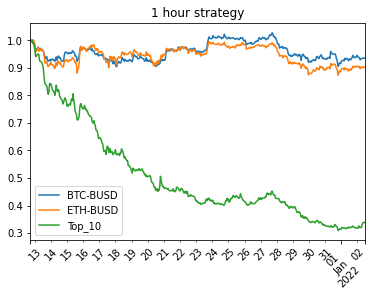

In [84]:
ax_1h = df_ret_1h.plot(title="1 hour strategy", rot=45)
fig_1h = ax_1h.get_figure()
fig_1h.savefig('../data/binance_benchmark/plots/1h_strategy.pdf')

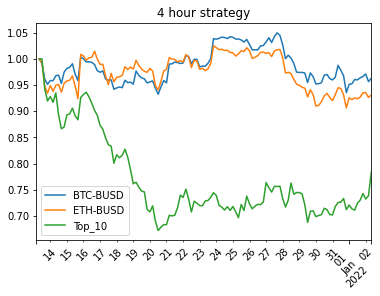

In [85]:
ax_4h = df_ret_4h.plot(title="4 hour strategy", rot=45)
fig_4h = ax_4h.get_figure()
fig_4h.savefig('../data/binance_benchmark/plots/4h_strategy.pdf')

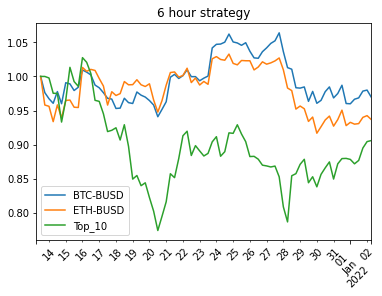

In [86]:
ax_6h = df_ret_6h.plot(title="6 hour strategy", rot=45)
fig_6h = ax_6h.get_figure()
fig_6h.savefig('../data/binance_benchmark/plots/6h_strategy.pdf')

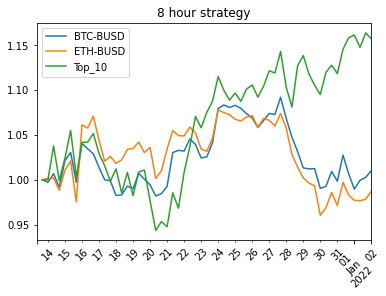

In [87]:
ax_8h = df_ret_8h.plot(title="8 hour strategy", rot=45)
fig_8h = ax_8h.get_figure()
fig_8h.savefig('../data/binance_benchmark/plots/8h_strategy.pdf')

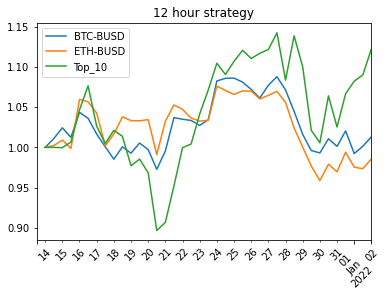

In [88]:
ax_12h = df_ret_12h.plot(title="12 hour strategy", rot=45)
fig_12h = ax_12h.get_figure()
fig_12h.savefig('../data/binance_benchmark/plots/12h_strategy.pdf')

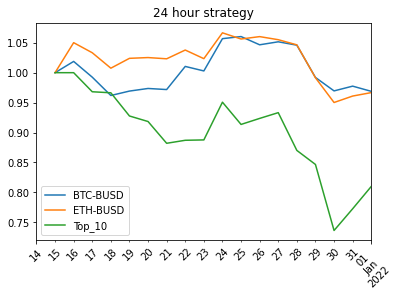

In [89]:
ax_24h = df_ret_24h.plot(title="24 hour strategy", rot=45)
fig_24h = ax_24h.get_figure()
fig_24h.savefig('../data/binance_benchmark/plots/24h_strategy.pdf')

In [4]:
def get_top_10(open_path):
    # Ik moet een forward selection maken waarbij ik de tickers voorspel in de volgende periode

    df = pd.DataFrame(columns=["date", "open", "high", "low", "close", "volume", "pct_change_24h", "ticker"])
    
    for filename in os.listdir(open_path):
        df_temp = pd.read_csv(f"{open_path}/{filename}")
        df = pd.concat([df, df_temp])


    df_12h = df.sort_values(by=['date', 'pct_change_24h'], ascending=False)
    
    df_time = pd.DataFrame(columns=["date", "pct_change"])
    time_list = df['date'].unique()

    for time in time_list:
        df_select_time = df_12h.loc[df_12h["date"] == time]

        df_select_time = df_select_time.iloc[:10]
        pct_change = df_select_time["pct_change_24h"].mean()
        df_mean = pd.DataFrame({time: pct_change}.items(), columns=["date", "pct_change"])

        df_time = pd.concat([df_time, df_mean])

    return df_time

In [29]:
# def get_top_10_1h(open_path):

#     df_1h = pd.DataFrame(columns=["date", "open", "high", "low", "close", "volume", "pct_change_24h", "ticker"])

#     for filename in os.listdir(open_path):
#         df_temp = pd.read_csv(f"{open_path}/{filename}")
#         df_1h = pd.concat([df_1h, df_temp])
    
#     df_1h['pct_change'] = df_1h['pct_change_24h']

#     return df_1h

In [30]:
# open_path_1 = "../data/binance_benchmark/one_hour"
open_path_4 = "../data/binance_benchmark/four_hours"
open_path_6 = "../data/binance_benchmark/six_hours"
open_path_8 = "../data/binance_benchmark/eight_hours"
open_path_12 = "../data/binance_benchmark/twelve_hours"
open_path_24 = "../data/binance_benchmark/twentyfour_hours"

# df_sorted_1 = get_top_10_1h(open_path_1)
df_sorted_4 = get_top_10(open_path_4)
df_sorted_6 = get_top_10(open_path_6)
df_sorted_8 = get_top_10(open_path_8)
df_sorted_12 = get_top_10(open_path_12)
df_sorted_24 = get_top_10(open_path_24)

KeyboardInterrupt: 

In [36]:
# df_sorted_1_t = df_sorted_1.set_index('date')
# df_sorted_1_t.plot(title="1 hour strategy", rot=45)
df4 = get_top10_picks(df_sorted_4)

,date,pct_change
0,2021-12-13 04:00:00,0.020595
0,2021-12-13 08:00:00,0.045069
0,2021-12-13 12:00:00,0.053490
0,2021-12-13 16:00:00,-0.002331
0,2021-12-13 20:00:00,0.029639
0,2021-12-14 00:00:00,0.086363
0,2021-12-14 04:00:00,0.039746
0,2021-12-14 08:00:00,0.104073
0,2021-12-14 12:00:00,0.063846
0,2021-12-14 16:00:00,0.038104


In [35]:
df_sorted_4_t = cummulative_returns(df_sorted_4.set_index('date'))
df_sorted_4_t
# df_sorted_4_t.plot(title="4 hour strategy", rot=45)

,pct_change
2021-12-13 04:00:00,1.020595
2021-12-13 08:00:00,1.066592
2021-12-13 12:00:00,1.123644
2021-12-13 16:00:00,1.121025
2021-12-13 20:00:00,1.154251
2021-12-14 00:00:00,1.253936
2021-12-14 04:00:00,1.303776
2021-12-14 08:00:00,1.439464
2021-12-14 12:00:00,1.531368
2021-12-14 16:00:00,1.589719


<AxesSubplot:title={'center':'6 hour strategy'}, xlabel='date'>

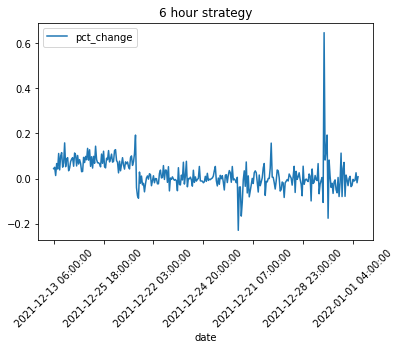

In [14]:
df_sorted_6_t = df_sorted_6.set_index('date')
df_sorted_6_t.plot(title="6 hour strategy", rot=45)

<AxesSubplot:title={'center':'8 hour strategy'}, xlabel='date'>

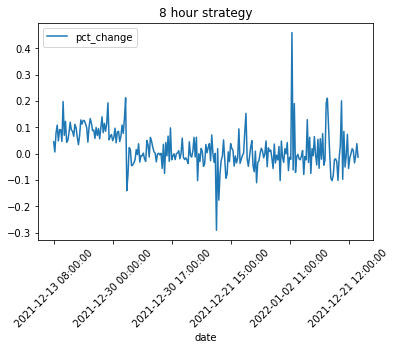

In [15]:
df_sorted_8_t = df_sorted_8.set_index('date')
df_sorted_8_t.plot(title="8 hour strategy", rot=45)

<AxesSubplot:title={'center':'12 hour strategy'}, xlabel='date'>

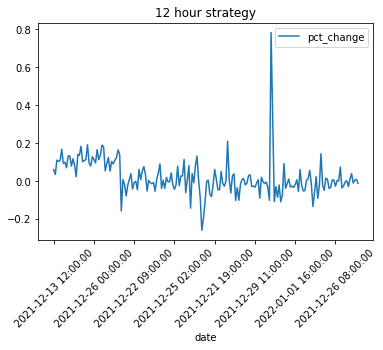

In [16]:
df_sorted_12_t = df_sorted_12.set_index('date')
df_sorted_12_t.plot(title="12 hour strategy", rot=45)

<AxesSubplot:title={'center':'24 hour strategy'}, xlabel='date'>

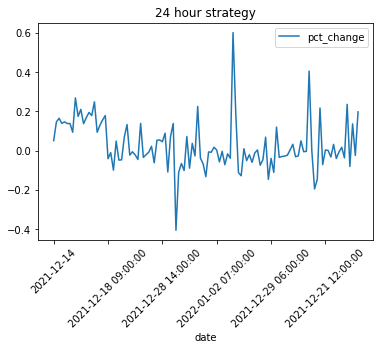

In [17]:
df_sorted_24_t = df_sorted_24.set_index('date')
df_sorted_24_t.plot(title="24 hour strategy", rot=45)